# Trains a ResNet on the CIFAR10 dataset.
### Dr. Tirthajyoti Sarkar, Fremont, CA

* **ResNet paper 1**: https://arxiv.org/pdf/1512.03385.pdf (**a**)
* **ResNet paper 2**: https://arxiv.org/pdf/1603.05027.pdf (**b**)

### About CIFAR-10 dataset

Website: https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

### Training parameters

In [2]:
data_augmentation = True
num_classes = 10

### Subtracting pixel mean improves accuracy

In [3]:
subtract_pixel_mean = True

### How many layers? Depends on the model version

In [4]:
def model_depth(version,n=3):
    """
    Computes depth from supplied model parameter n
    """
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2
    return depth

In [5]:
def model_type(version,n):
    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (model_depth(version,n), version)
    return model_type

In [7]:
model_t = model_type(2,3)
print(model_t)

ResNet29v2


### Function to show any data

In [6]:
def show_data(sample):
    """
    Shows the given sample data as an image
    """
    import matplotlib.pyplot as plt
    plt.imshow(sample)
    plt.show()

### Load the CIFAR10 data

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


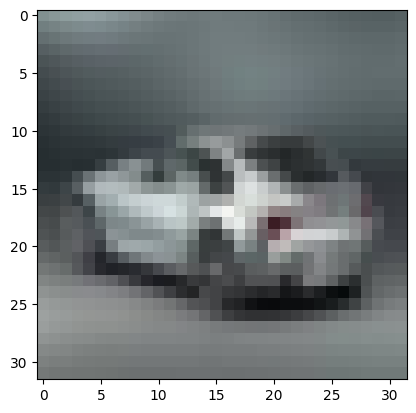

In [9]:
show_data(x_train[250])

In [10]:
# Input image dimensions.
input_shape = x_train.shape[1:]

In [11]:
print(input_shape)

(32, 32, 3)


### Normalize data

In [12]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
show_data(x_train[250])

### If `subtract_pixel_mean` is enabled

In [13]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [14]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
show_data(x_train[250])

### Convert class vectors to binary class matrices

In [16]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Function for auto-scaling learning based on epochs

In [17]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

### Function of a single ResNet layer

In [18]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

### ResNet Version 1 model builder

In [19]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

### ResNet Version 2 model builder

In [20]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Choose model

In [21]:
def choose_model(version=1):
    """
    Chooses the model based on version

    # Argument:
        An (int) version number (1 or 2)
    # Returns:
        keras model
    """
    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)
    return model

### Choose version, parameter `n`, compile, and show summary

In [22]:
version = 1
n = 3

In [23]:
depth = model_depth(version=version,n=n)
model = choose_model(version)

In [24]:
print(model_type(version,n))

ResNet20v1


In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['ba

In [26]:
print("There are, in total, {} parameters in this model!".format(model.count_params()))

There are, in total, 274442 parameters in this model!


### Prepare model saving directory

In [27]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

### Prepare callbacks for model saving and for learning rate adjustment


In [28]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             period=3
                            )

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [29]:
# For now, we will not save the models, so won't include the `checkpoint` in the `callbacks`
callbacks = [lr_reducer, lr_scheduler]

### Training (sit back and enjoy a cuppa, because this is gonna take some time!)
First start with a very small number of epochs to check the training speed on your particular hardware. Thereafter, adjust accordingly.

In [30]:
from time import time

In [31]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 20

In [32]:
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time()

Learning rate:  0.001
Epoch 1/20
1563/1563 [==============================] - 52s 18ms/step - loss: 1.4661 - accuracy: 0.5260 - val_loss: 1.3946 - val_accuracy: 0.5789 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0611 - accuracy: 0.6815 - val_loss: 1.4826 - val_accuracy: 0.5662 - lr: 0.0010
Learning rate:  0.001
Epoch 3/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9009 - accuracy: 0.7414 - val_loss: 1.1183 - val_accuracy: 0.6669 - lr: 0.0010
Learning rate:  0.001
Epoch 4/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7960 - accuracy: 0.7826 - val_loss: 1.0227 - val_accuracy: 0.7155 - lr: 0.0010
Learning rate:  0.001
Epoch 5/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7264 - accuracy: 0.8081 - val_loss: 0.8914 - val_accuracy: 0.7580 - lr: 0.0010
Learning rate:  0.001
Epoch 6/20
1563/1563 [==============================] - 27s 17ms/step - l

In [33]:
model.save("model_resnet01.h6")
import zipfile, os
folder_path = 'model_resnet01.h6'
zip_file_name = 'model_resnet01.h6.zip'

def zip_folder(folder_path, zip_file_name):
    zip_file = zipfile.ZipFile(zip_file_name, 'w')

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zip_file.write(os.path.join(root, file))

    zip_file.close()
zip_folder(folder_path, zip_file_name)

In [34]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 20 epochs took 10.49 minutes total.


### Score trained model

In [35]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 7ms/step - loss: 1.0144 - accuracy: 0.7930
Test loss: 1.0144305229187012
Test accuracy: 0.7929999828338623


### A smaller learning rate and larger batch size

In [ ]:
# Note, we turn off the callbacks as we want to use the new learning rate
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True)
t2 = time()

In [ ]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Sử dụng lại model dùng resnet v1 và Fit with data augmentation

In [46]:
import tensorflow as tf
model = tf.keras.models.load_model('model_resnet01.h6')


In [49]:
batch_size = 64
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [50]:
t1 = time()
r = model.fit(train_generator, validation_data=(x_test, y_test),
			steps_per_epoch=steps_per_epoch, epochs=50)

t2 = time()

Epoch 1/50
781/781 [==============================] - 38s 49ms/step - loss: 0.4794 - accuracy: 0.9052 - val_loss: 0.6346 - val_accuracy: 0.8599
Epoch 2/50
781/781 [==============================] - 39s 50ms/step - loss: 0.4685 - accuracy: 0.9048 - val_loss: 0.6891 - val_accuracy: 0.8447
Epoch 3/50
781/781 [==============================] - 38s 48ms/step - loss: 0.4672 - accuracy: 0.9051 - val_loss: 0.6672 - val_accuracy: 0.8526
Epoch 4/50
781/781 [==============================] - 37s 48ms/step - loss: 0.4665 - accuracy: 0.9045 - val_loss: 0.6267 - val_accuracy: 0.8572
Epoch 5/50
781/781 [==============================] - 39s 50ms/step - loss: 0.4633 - accuracy: 0.9041 - val_loss: 0.7012 - val_accuracy: 0.8410
Epoch 6/50
781/781 [==============================] - 39s 50ms/step - loss: 0.4651 - accuracy: 0.9013 - val_loss: 0.6181 - val_accuracy: 0.8558
Epoch 7/50
781/781 [==============================] - 39s 50ms/step - loss: 0.4551 - accuracy: 0.9062 - val_loss: 0.8148 - val_accuracy:

In [51]:
model.save("model_resnet03.h6")
import zipfile, os
folder_path = 'model_resnet03.h6'
zip_file_name = 'model_resnet03.h6.zip'

def zip_folder(folder_path, zip_file_name):
    zip_file = zipfile.ZipFile(zip_file_name, 'w')

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zip_file.write(os.path.join(root, file))

    zip_file.close()
zip_folder(folder_path, zip_file_name)

In [52]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 20 epochs took 33.55 minutes total.


In [53]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.6093 - accuracy: 0.8620
Test loss: 0.60933518409729
Test accuracy: 0.8619999885559082


### With ResNet v2 model

In [ ]:
version = 2
n = 5

depth = model_depth(version=version,n=n)
model = choose_model(version)

print("Model type:",model_type(version,n))
print("There are, in total, {} parameters in this model!".format(model.count_params()))

Model type: ResNet47v2
There are, in total, 1398826 parameters in this model!


In [ ]:
# Hard coding the learning rate = 3e-4
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=3e-4),
              metrics=['accuracy'])

In [ ]:
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 20

In [ ]:
# Note, we turn off the callbacks as we want to use the new learning rate
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True)
t2 = time()

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 110s 2ms/step - loss: 2.4201 - acc: 0.4460 - val_loss: 2.2206 - val_acc: 0.4953
Epoch 2/20
50000/50000 [==============================] - 80s 2ms/step - loss: 1.9250 - acc: 0.5916 - val_loss: 1.8745 - val_acc: 0.5946
Epoch 3/20
50000/50000 [==============================] - 80s 2ms/step - loss: 1.6684 - acc: 0.6650 - val_loss: 1.7502 - val_acc: 0.6214
Epoch 4/20
50000/50000 [==============================] - 81s 2ms/step - loss: 1.4783 - acc: 0.7201 - val_loss: 1.7839 - val_acc: 0.5964
Epoch 5/20
50000/50000 [==============================] - 81s 2ms/step - loss: 1.3153 - acc: 0.7691 - val_loss: 1.9695 - val_acc: 0.5663
Epoch 6/20
50000/50000 [==============================] - 81s 2ms/step - loss: 1.1650 - acc: 0.8159 - val_loss: 2.0570 - val_acc: 0.5618
Epoch 7/20
50000/50000 [==============================] - 81s 2ms/step - loss: 1.0283 - acc: 0.8606 - val_loss: 1.7825 - val_ac

In [ ]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 20 epochs took 27.57 minutes total.


In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 8s 773us/step
Test loss: 2.2992931884765624
Test accuracy: 0.647


### More variation and longer training...

In [ ]:
version = 1
n = 4

depth = model_depth(version=version,n=n)
model = choose_model(version)

print("Model type:",model_type(version,n))
print("There are, in total, {} parameters in this model!".format(model.count_params()))

Model type: ResNet26v1
There are, in total, 372330 parameters in this model!


In [ ]:
# Hard coding the learning rate = 1e-3
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy'])

In [ ]:
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50

In [ ]:
callbacks = [lr_reducer]

In [ ]:
# Note, we turn off the callbacks as we want to use the new learning rate
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 32s 631us/step - loss: 1.0204 - acc: 0.7070 - val_loss: 1.3248 - val_acc: 0.6230
Epoch 2/50
50000/50000 [==============================] - 31s 621us/step - loss: 0.8886 - acc: 0.7562 - val_loss: 1.8254 - val_acc: 0.5249
Epoch 3/50
50000/50000 [==============================] - 31s 622us/step - loss: 0.7859 - acc: 0.7894 - val_loss: 0.9916 - val_acc: 0.7328
Epoch 4/50
50000/50000 [==============================] - 31s 624us/step - loss: 0.7010 - acc: 0.8206 - val_loss: 1.5349 - val_acc: 0.6127
Epoch 5/50
50000/50000 [==============================] - 31s 630us/step - loss: 0.6452 - acc: 0.8400 - val_loss: 0.9615 - val_acc: 0.7466
Epoch 6/50
50000/50000 [==============================] - 31s 630us/step - loss: 0.5894 - acc: 0.8588 - val_loss: 0.9448 - val_acc: 0.7522
Epoch 7/50
50000/50000 [==============================] - 32s 636us/step - loss: 0.5459 - acc: 0.8761 - val_loss: 1.

In [ ]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 50 epochs took 26.55 minutes total.


In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 432us/step
Test loss: 1.1410504387378693
Test accuracy: 0.8073
